In [1]:
#Import des librairies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')




In [2]:
#Scraping de données
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('today')

df_stock = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)
df_vix = web.DataReader('^VIX', data_source='yahoo', start=start, end=end)


In [3]:
# Taille des données
print(df_stock.shape)
print(df_vix.shape)

(2251, 6)
(2251, 6)


In [4]:
# Création de la moyenne mobile exponentielle
ema = pd.Series.ewm(df_stock['Close'], span=30).mean()

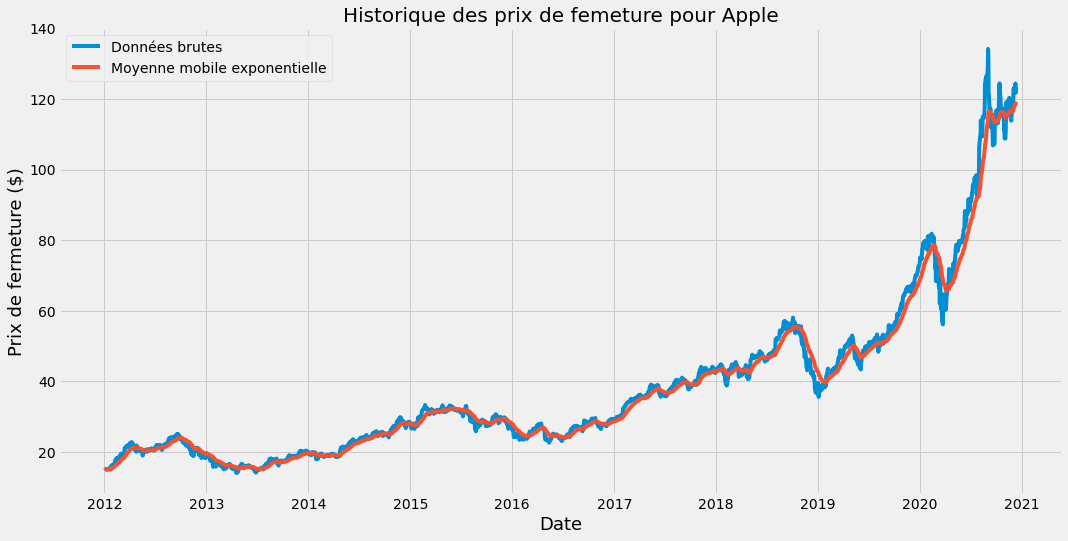

In [5]:
# Visualisation des prix de fermeture
plt.figure(figsize=(16,8))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
plt.plot(df_stock['Close'])
plt.plot(ema)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.legend(['Données brutes','Moyenne mobile exponentielle'])
plt.show()

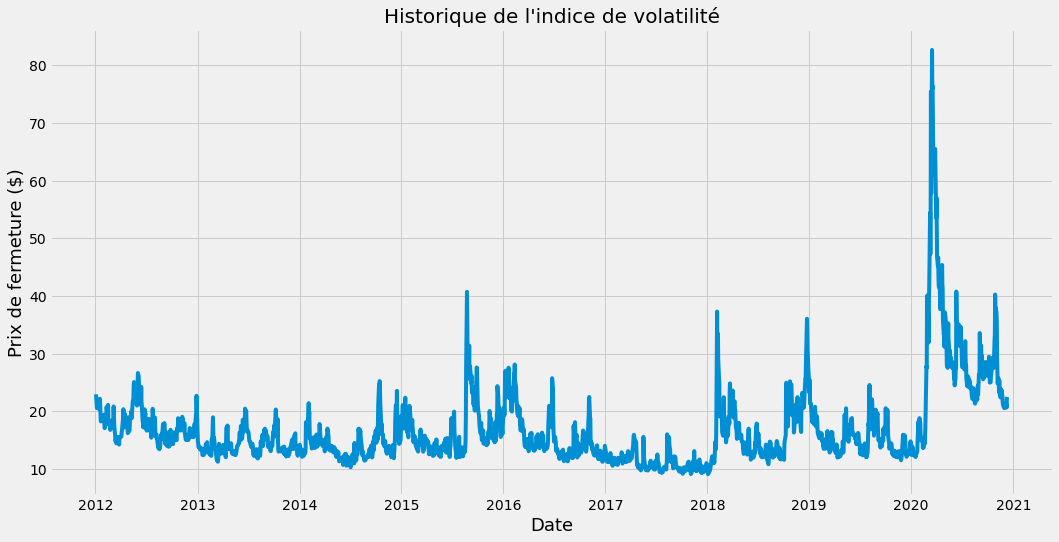

In [6]:
# Visualisation du VIX
plt.figure(figsize=(16,8))
plt.title("Historique de l'indice de volatilité", fontsize=20)
plt.plot(df_vix['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.show()

In [7]:
#On ne s'intéresse qu'aux prix de fermeture
data_stock = df_stock.filter(['Close'])
data_vix = df_vix.filter(['Close'])

#On convertit les données en numpy array
dataset_stock = data_stock.values
dataset_vix = data_vix.values
dataset_ema = np.reshape(ema.values,(len(ema),1))
#Taille des données d'entraînement
training_data_len = int(len(dataset_stock) * 0.8)
training_data_len


1800

In [8]:
#Normalisation des données
scaler_stock = MinMaxScaler(feature_range=(0,1))
scaled_stock = scaler_stock.fit_transform(dataset_stock)

scaler_vix = MinMaxScaler(feature_range=(0,1))
scaled_vix = scaler_vix.fit_transform(dataset_vix)

scaler_ema = MinMaxScaler(feature_range=(0,1))
scaled_ema = scaler_ema.fit_transform(dataset_ema)

scaled_data=np.concatenate((scaled_stock,scaled_vix,scaled_ema),axis=1)

In [9]:
#Création des données d'entraînement
train_data = scaled_data[0:training_data_len, :]
#Création de X_train and y_train
X_train_stock = []
X_train_vix = []
X_train_ema = []
y_train = []

for k in range(60,len(train_data)):
    X_train_stock.append(train_data[k-60:k,0])
    X_train_vix.append(train_data[k-60:k,1])
    X_train_ema.append(train_data[k-60:k,2])
    y_train.append(train_data[k,0])


In [10]:
#On met les données d'entraînement en numpy array
X_train_stock, X_train_vix, y_train = np.array(X_train_stock), np.array(X_train_vix), np.array(y_train)
X_train_ema = np.array(X_train_ema)

In [11]:
#Les données doivent être tridimensionnelles pour notre modèle
X_train_stock = np.reshape(X_train_stock, (X_train_stock.shape[0],X_train_stock.shape[1],1))
X_train_vix = np.reshape(X_train_vix, (X_train_vix.shape[0],X_train_vix.shape[1],1))
X_train_ema = np.reshape(X_train_ema, (X_train_ema.shape[0],X_train_ema.shape[1],1))
X_train = np.concatenate((X_train_stock,X_train_vix,X_train_ema),axis=2)

In [15]:
#Création des données de test
test_data = scaled_data[training_data_len - 60: , :]
#Création de X_test et y_test
X_test_stock=[]
X_test_vix=[]
X_test_ema=[]
y_test = []
y_naif = []

for k in range(60,len(test_data)):
    X_test_stock.append(test_data[k-60:k,0])
    X_test_vix.append(test_data[k-60:k,1])
    X_test_ema.append(test_data[k-60:k,2])
    y_test.append(test_data[k,0])
    y_naif.append(test_data[k-1,0])

In [16]:
#On met les données d'entraînement en numpy array
X_test_stock, X_test_vix, X_test_ema = np.array(X_test_stock), np.array(X_test_vix), np.array(X_test_ema)  
y_test, y_naif = np.array(y_test), np.array(y_naif)

In [17]:
#Les données doivent être tridimensionnelles pour notre modèle
X_test_stock = np.reshape(X_test_stock, (X_test_stock.shape[0],X_test_stock.shape[1],1))
X_test_vix = np.reshape(X_test_vix, (X_test_vix.shape[0],X_test_vix.shape[1],1))
X_test_ema = np.reshape(X_test_ema, (X_test_ema.shape[0],X_test_ema.shape[1],1))
X_test = np.concatenate((X_test_stock,X_test_vix,X_test_ema),axis=2)

In [29]:
from tensorflow import keras
model = keras.models.load_model('C:\\Users\\User\\Desktop\\Predictions\\model.npy')

In [30]:
#Prédiction
prediction_scaled = model.predict(X_test)

prediction = scaler_stock.inverse_transform(prediction_scaled)

In [31]:
#Baseline
rmse = np.sqrt(np.mean(y_naif- y_test)**2)
rmse

0.0014744622318708558

In [38]:
#Calcul de l'erreur
prediction_scaled2 = np.reshape(prediction_scaled,y_test.shape)
rmse = np.sqrt(np.mean(prediction_scaled2 - y_test)**2)
rmse

0.0012584708531732085

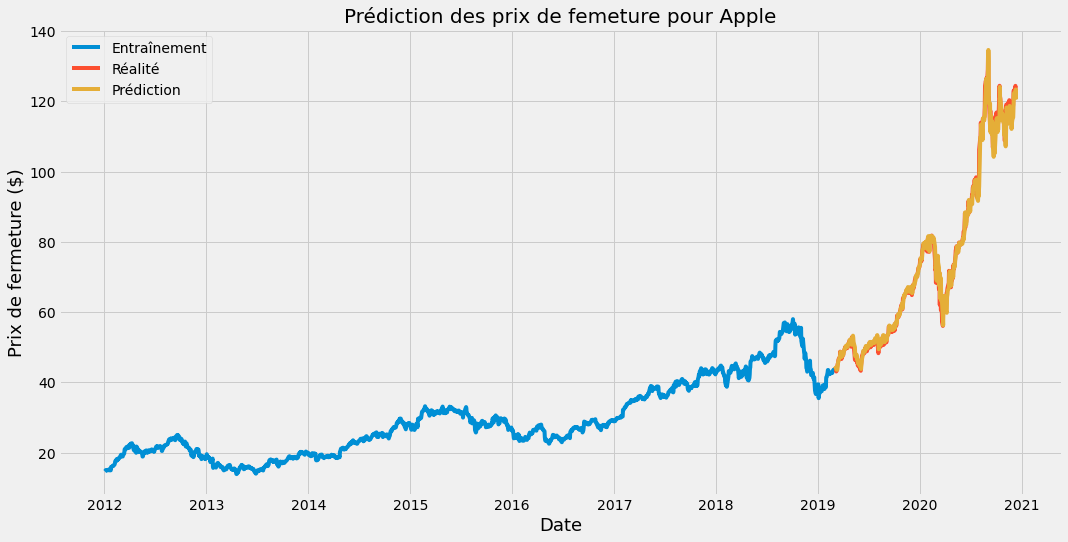

In [39]:
#Visualisation des résultats
train = data_stock[:training_data_len]
test = data_stock[training_data_len:].copy()
test['Prediction']=prediction


plt.figure(figsize=(16,8))
plt.title('Prédiction des prix de femeture pour Apple', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close','Prediction']])
plt.legend(['Entraînement','Réalité','Prédiction'])
plt.show()

In [40]:
#Montée - Descente

delta_reel = []
delta_prediction = []

for k in range (len(y_test)-1):
    delta_reel.append(y_test[k+1] - y_test[k])
    delta_prediction.append(prediction_scaled2[k+1] - y_test[k])

In [41]:
#Evaluation de la prédiction de Montée - Descente
c=0
for k in range (len(delta_reel)):
    if delta_reel[k]*delta_prediction[k] > 0:
        c+=1
        
c/len(delta_reel)

0.5311111111111111

In [42]:
y_test = np.reshape(y_test,(len(y_test),1))
y_test_reel = scaler_stock.inverse_transform(y_test)

In [43]:
np.save('C:\\Users\\User\\Desktop\\Predictions\\close_reel.npy',y_test_reel)

In [44]:
np.save('C:\\Users\\User\\Desktop\\Predictions\\close_prediction.npy',prediction)